### Lending Club Loan Data

The lending club loan data set (accessible on kaggle.com: https://www.kaggle.com/wendykan/lending-club-loan-data) contains data for loans in the period of 2007 - 2015. It includes, among others, information about current payments, the loan status (current, late, fully paid etc.) and data about the borrower such as state, annual income and home ownership. The complete data set consists of approximately 890.000 rows and 74 columns. 

### Objective

For this tutorial, we aim to implement a Bayesian neural network using the MC Dropout technique to predict profits for the lending club. 

(add: why we use bayesian instead of deterministic, importance of uncertainty)

### Data Exploration
Before we implement the Bayesian neural network, we will explore and clean the data. Because we are only interested in past loans, we have already created a new data set, for which we removed loans where the loan status is "current". We now have a data set with 285,600 rows and 74 columns.

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
loan = pd.read_csv("data/loans_Past.csv", low_memory=False)
#loan = loan.dropna(axis=1, how='all')

In [118]:
print(loan.shape)
loan.head()
#loan_all[["total_rec_prncp", "total_pymnt", "total_pymnt_inv", "loan_status"]]

(887379, 74)


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075269    1311441       5000         5000           5000.0   36 months   

   int_rate  installment grade sub_grade     ...      total_bal_il il_util  \
0     10.65       162.87     B        B2     ...               NaN     NaN   
1     15.27        59.83     C        C4     ...               NaN     NaN   
2     15.96        84.33     C        C5     ...               NaN     NaN   
3     13.49       339.31     C        C1     ...               NaN     NaN   
4      7.90       156.46     A        A4     ...               NaN     NaN   

  open_rv_12m  open_rv_24m max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN          NaN        NaN      NaN              NaN    NaN   
1         NaN          NaN        NaN      NaN              NaN    NaN   
2         NaN          NaN        NaN      NaN              NaN    NaN   
3         NaN          NaN        NaN      NaN              NaN    NaN   
4         NaN          NaN        NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 74 columns]

The first few rows of the data set show that some of the columns seem to have quite a lot of missing values.
In order to obtain a better overview, we start by creating a data set `loan_missing` which contains boolean values for missing data. We then sum those missing values by column and calculate the percentage. Lastly, we order the dataframe by the percentage of missing values, with the highest percentage on top.

In [89]:
loan_missing = loan.isna()
loan_missing_count = loan_missing.sum()

In [90]:
loan_missing_percentage = (loan_missing_count / len(loan)).round(4) * 100
loan_missing_sorted = loan_missing_percentage.sort_values(ascending=False)

In [91]:
loan_missing_sorted

dti_joint                      99.98
verification_status_joint      99.98
annual_inc_joint               99.98
il_util                        97.50
mths_since_rcnt_il             97.19
max_bal_bc                     97.12
open_rv_24m                    97.12
open_rv_12m                    97.12
all_util                       97.12
total_bal_il                   97.12
open_il_24m                    97.12
open_il_12m                    97.12
open_il_6m                     97.12
open_acc_6m                    97.12
total_cu_tl                    97.12
inq_fi                         97.12
inq_last_12m                   97.12
next_pymnt_d                   88.58
mths_since_last_record         86.81
mths_since_last_major_derog    80.24
desc                           67.56
mths_since_last_delinq         54.60
tot_cur_bal                    23.35
tot_coll_amt                   23.35
total_rev_hi_lim               23.35
emp_title                       5.61
emp_length                      4.11
l

The resulting table proves that a lot of columns are almost completely empty. We set a threshold of 50% and remove each column above this threshold. We now have 52 columns left.

In [123]:
temp = [i for i in loan.count()<len(loan)*0.50]
loan.drop(loan.columns[temp],axis=1,inplace=True)
loan.shape

(285600, 52)

Since there is no profit column existing in our data set, we define a target variable `profit` containing the profit rate. Now we look at the distribution of profits in order to find out if there are any imbalances in our target variable. We classify the target values as positive / negative profit and count the occurences.

In [124]:
loan["profit"] = loan.apply(lambda x: ((x['total_pymnt'] - x['loan_amnt'])/x['loan_amnt']), axis = 1)
loan["profit"] = loan["profit"].round(2)

target_class = pd.DataFrame(columns=["class"])
target_class["class"] = [1 if i > 0 else 0 for i in loan["profit"]]
target_class["class"].value_counts()

1    208985
0     76615
Name: class, dtype: int64

The profit classes show that there are far more instances of positive profit than negative profit, meaning that our data set is imbalanced. In order to avoid a biased prediction, we will need to balance the data later on.

Now, we will have a look at what variables have the highest positive and negative correlation with our target variable. 

In [95]:
loan.head()
corr = loan.corr()["profit"].sort_values(ascending=False)
print('most positive correlations:\n', corr.head(10))

print('most negative correlations:\n', corr.tail(10))
#corr = loan.corr()
#corr

most positive correlations:
 profit              1.000000
total_rec_prncp     0.551126
total_pymnt         0.515352
total_pymnt_inv     0.510558
last_pymnt_amnt     0.362307
total_rec_int       0.218768
tot_cur_bal         0.040476
annual_inc          0.020393
total_rev_hi_lim    0.004064
inq_last_6mths      0.000856
Name: profit, dtype: float64
most negative correlations:
 loan_amnt                 -0.079100
int_rate                  -0.100841
collection_recovery_fee   -0.137428
dti                       -0.146143
recoveries                -0.229157
id                        -0.481423
member_id                 -0.482082
out_prncp                 -0.543330
out_prncp_inv             -0.543338
policy_code                     NaN
Name: profit, dtype: float64


The columns `total_rec_prncp` (prinicpal received to date), `total_pymnt` (payments received to date for total amount funded) and `total_pymnt_inv` (payments received to date for portion of total amount funded by investors) have the highest positive correlation with our target column. 
The columns `out_prncp` (remaining outstanding principal for total amount funded) and `out_prncp_inv` (remaining outstanding principal for portion of total amount funded by investors) have the highest negative correlation with the target column.

(makes sense for past loans, but for current loans which will be predicted may not necessarily be as significant)

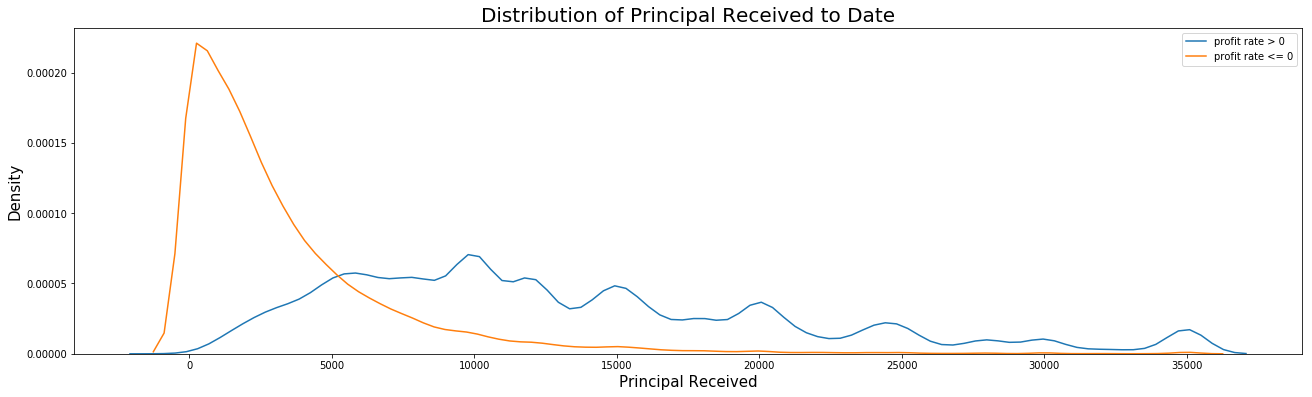

In [126]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(loan.loc[loan['profit'] > 0, 'total_rec_prncp'], label = 'profit rate > 0')
sns.kdeplot(loan.loc[loan['profit'] <= 0, 'total_rec_prncp'], label = 'profit rate <= 0');
plt.xlabel('Principal Received',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Principal Received to Date',fontsize=20);

The distribution of principal received to date shows that most instances with negative profits appear in the range of 0 - 10,000$, whereas instances with positive profits are more widely distributed.  

In [135]:
loan['member_id'].value_counts().head()

0.0

There are no members who have taken more than one loan. Consequently, the member id does not indicate whether the borrower is likely to pay back their loan. Hence, the column does not need to be considered for predictions. 

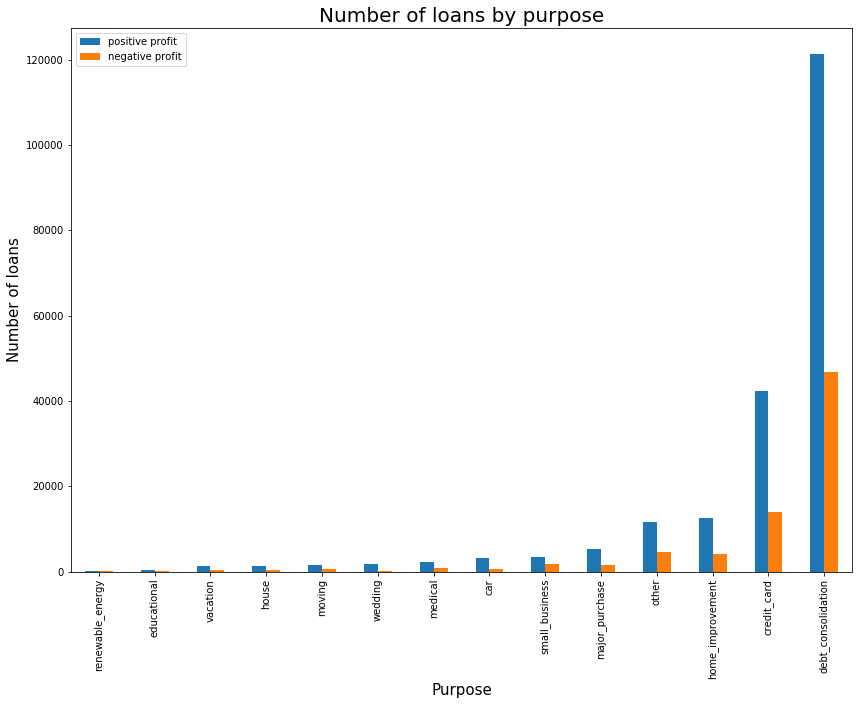

In [169]:
profit_by_purpose = pd.DataFrame(loan[loan['profit']>0].groupby('purpose')['profit'].count().sort_values())
profit_by_purpose["profit_neg"] = pd.DataFrame(loan[loan['profit']<=0].groupby('purpose')['profit'].count().sort_values())["profit"]

fig, ax = plt.subplots(figsize=(14, 10))
profit_by_purpose.plot(kind="bar", ax=ax)
plt.ylabel('Number of loans',fontsize=15)
plt.xlabel('Purpose',fontsize=15)
plt.title('Number of loans by purpose', fontsize=20);
L=plt.legend()
L.get_texts()[0].set_text('positive profit')
L.get_texts()[1].set_text('negative profit')

The barplot shows that most loans are issued for debt consolidation and credit cards - these are also the categories with the highest amount of loans with negative profit. There is no category where the amount of loans with negative profits exceeds loans with positive profits. However, there certainly are categories where the share of negative profits is very small, such as house, car or wedding.

#### Balance Data

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


sm = SMOTE(random_state=43, ratio = 1.0)
x_train_new, y_train_new = sm.fit_sample(x_train, y_train)